In [28]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>''')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer 
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.cluster import SpectralCoclustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from itertools import combinations
from wordcloud import WordCloud
from PIL import Image
# nltk.download('stopwords')
# nltk.download('wordnet')

<figure>
  <img src="christopher-alvarenga-OlxU3VfTI8w-unsplash.jpg"/>
  <figcaption>Photo by Christopher Alvarenga</figcaption>
</figure> 


# Extracting Customer Insights from Las Vegas Filipino Restaurants

## 1 Executive Summary

Filipino food lacks precense in the mainsteam international market. Its unorthodox use of ingredients has made it difficult for foreigners to appreciate. Despite this, The Department of Trade and Industry (DTI) is strategizing a plan to further research and develop Filipino cuisine. To further understand how Filipino restaurants can be marketed, the study examines customer reviews of different Filipino Restaurants in Las Vegas.

The list of reviews were collected from Yelp datasets `yelp_academic_dataset_review` and `yelp_academic_dataset_business`. The feature `text` was used for Machine Learning while the features `stars`, `useful`, `cool`and `funny` were used to interpret the topic clusters. Several data pre-processing methods were applied such as removal of punctuations, trimming of trailing white spaces, lemmatization and vectoriztion. Afterwards, the TF model was used in topic modeling by Latent Dirichlet Allocation (**LDA**). The relevance of the topic clusters were evaluated using coherence scores measure by Pointwise Mutual Information (**PMI**). Over-all, 16 topics were formed with reasonable coherence using LDA. 

This study culminates with a recommendation to optimize hyperparameters of Latent Dirichlet Allocation model. In addition, the authors also recommend to apply other etrinsic validation scoring functions to compare topic coherence with intrinsic measuring scores.

## 2 Introduction

### Background
DTI has been promoting Filipino cuisine in the world stage. Senen Perlada, director of the Export Marketing Bureau of DTI, envisions that Filipino cuisine will not just be catering to Filipinos abroad, but also the mainstream international market. For instance, the Philippines showcased Filipino ingredients during its participation in the ASEAN Culinary Show in Bangkok. Its successful showcase of Bangus, coconut milk, etc. in the culinary show has proved that Filipino food has potential in the international stage. This move has prompt DTI to consider supporting the research and development of Filipino food and inviting international buyers (Salcedo, 2019).

### Problem Statement
According to Cruz (2019), Filipino food is "one of the worst" from a Western perspective. Despite the desire for Filipino cuisine to have international recognition, Filipino cuisine is not exotic enough to pique interest from outsiders. The lack of spices, unconventional use of ingredients, and focus on sourness keeps the cuisine only within the comfort of Filipinos. Hence, DTI faces the challenge of marketing Filipino cuisine to the mainstream international market. 

### Thesis Statement
This study proposes to use Yelp reviews of 70 Las Vegas-based Filipino restaurants for identifying mainstream international market sentiments of the cuisine. To achieve this, the model incorporates Latent Dirichlet Allocation (LDA) and K-Means clustering.

### Significance of the Study
There are three types of beneficiaries of this research - DTI, Filipino food technology companies, and Filipino restaurants. First, DTI would able to use such research on strategizing for food and research development of Filipino cuisine. Second, Filipino food technology companies would be able to use the research for better marketing of premium Filipino ingredients to the mainstream international market. Lastly, Filipino restaurants would be able to use this research for the market opportunity analysis of the market.

### Scope and Limitations

The research is limited to Las Vegas-based Filipino restaurant reviews to represent the mainstream international market sentiment. It only considers Filipino restaurant reviews dated from 2006 to 2018. All in all, there are about 7000 reviews about Filipino restaurants in the dataset.

## 3 Data Scope and Description
### Data Description
The two concerning dataset is from the Yelp Open Dataset provided in Yelp Website. The files are available as a JSON file called `yelp_academic_dataset_review.json` and `yelp_academic_dataset_business`. The JSON file is converted into a CSV file called `filipino_las_vegas.csv`. 

As of September 1, 2020, there are 8,021,122 user reviews, 209,393 business information, and 1 metropolitan areas in the Yelp dataset. Moreover, the review dataset's nine features with their corresponding data type and description are shown in Table 1.

#### Table 3.1 Data Attributes and Description of Yelp Business Dataset

|    Feature    | Data Type |            Description           |
|:-------------:|:---------:|:--------------------------------:|
|  `review_id`  |   string  |   22 character unique review id  |
|   `user_id`   |   string  |    22 character unique user id   |
| `business_id` |   string  |     22 character business id     |
|    `stars`    |  integer  |    star rating of the business   |
|     `date`    |   string  | review date formatted YYYY-MM-DD |
|     `text`    |   string  |          business review         |
|    `useful`   |  integer  |  number of useful votes received |
|    `funny`    |  integer  |  number of funny votes received  |
|     `cool`    |  integer  |   number of cool votes received  |

The business dataset's 14 features with their corresponding data type and description are shown in Table 2. 

#### Table 2. Data Attributes and Description of Yelp Reviews Dataset

|     Feature    | Data Type |                              Description                             |
|:--------------:|:---------:|:--------------------------------------------------------------------:|
|  `business_id` |   string  |                     22 character unique review id                    |
|     `name`     |   string  |                             business name                            |
|    `address`   |   string  |                         business full address                        |
|     `city`     |   string  |                     city location of the business                    |
|     `state`    |   string  |                two character state code, if applicable               |
|  `postal code` |   string  |                              postal code                             |
|   `latitude`   |   float   |                               latitude                               |
|   `longitude`  |   float   |                               longitude                              |
|     `stars`    |   float   |                              star rating                             |
| `review_count` |  integer  |                           number of reviews                          |
|    `is_open`   |  integer  |                         0 = closed, 1 = open                         |
|  `attributes`  |   object  | business attributes (e.g. RestaurantsTakeOut, BusinessParking, etc.) |
|  `categories`  |   string  |       Category of Business (e.g. Mexican, Burgers, Gastropubs)       |
|     `hours`    |   Object  |               day to hours (e.g. Monday: "10:00-21:00")              |

In [25]:
def fetch_filipino_las_vegas():
    ## open the yeld business dataset
    with open('/mnt/data/public/yelp/challenge12/yelp_dataset/yelp_academic_dataset_business.json') as f:
        h = f.readlines()

    ## read as json
    df_b_container = []
    for i in tqdm(range(len(h))):
        df_b_container.append(pd.DataFrame(json.loads(h[i]), index=range(i,i+1)))

    ## filter  las vegas among cities
    las_vegas = [df.loc[df['city'] == 'Las Vegas'] for df in df_b_container]

    ## concatenate dataframs of las vegas
    concat_las_vegas = pd.concat(las_vegas, axis=0)
    
    ## fill  na values with empty string
    concat_las_vegas['categories'].fillna('', inplace=True)
    
    ## find filipino restaurants in las vegas
    filipino = concat_las_vegas[concat_las_vegas['categories'].str.contains('Filipino')]

    ## store the business_id of filipino restaurants in las vegas
    filipino_list = filipino['business_id'].to_list()

    ## open yelp reviews dataset
    with open('/mnt/data/public/yelp/challenge12/yelp_dataset/yelp_academic_dataset_review.json') as f:
        g = f.readlines()

    ## query the business_of of filipino restaurants in reviews dataset
    df_container = []
    for i in tqdm(range(len(g))):
        if json.loads(g[i])['business_id'] in filipino_list:
            df_container.append(pd.DataFrame(json.loads(g[i]), index=range(i,i+1)))

    ## combine dataframes of reviews of filipino restaurants in las vegas
    filipino_las_vegas = pd.concat(df_container, axis=0)
    
    return filipino_las_vegas

## 4 Methodology


In this section, the methodology used for topic modeling of customer reviews were laid-out and brief discussions were given. The methodology covers from data subset selection, feature selection, vectorization, down to topic clusters exploration. More speciific details for each step can be found in subsequent sections. The overall backbone methodology is expressed in **Figure 4.1**.


#### Figure 4.1 Over-All Methodology

<img src="MicrosoftTeams-image.png"/>

The main objective of this study to discover hidden latent topics from the customer reviews of Filipino restaurants in Las Vegas. The raw data is expansive and covers all types of restaurant across the globe. Thus, the study was limited to Filipino Restaurants in Las Vegas, in both interest of the authors of this report. Hence, the first step includes subset selection from the raw dataset. Two datasets were used: `yelp_academic_dataset_review` and `yelp_academic_dataset_business`. The former dataset was used to retrieve the `business_id` of Filipino Restaurants in Las Vegas. There is a categorical variable available to filter Filipino Restaurants from the list. The `business_id` was then used to retrieve the customer reviews in the former dataset. Only the features `text`, `stars`, `useful`, `funny`, and `cool` were used in the machine learning. The last four features are indicative descriptions of the reviews. The feature `text` is the most important feature and the one used for Latent Dirichlet Allocation (**LDA**).

The next step invovles data pre-processing. Though the given data is already in a structured format, it is not in immediate usable form. That is, the text data must be pre-processed, vectorized, and represented in a model suitable for LDA method. The are many stages involved in data pre-processing. These are
- **(1)** removal of special characters
- **(2)** trimming of white spaces
- **(3)** removal of conjuctive punctuations
- **(4)** filtering of stopwords
- **(5)** lemmatization
- **(6)** vectorization (TF model)

Each pre-processing step is thouroughly discussed in section 5. The objective of data pre-processing step is to transform the text data into Token-Frequency (TF) model which can be directly fed in Latent Dirichlet Allocation. Punctuations, special characters, irrelevant tokens and semantically not useful words must be removed to come up with more interpretable topic clusters in the LDA.

The third step is the heart of the methodology. Latent Dirichlet Allocation is a dimensionality reduction technique which is almost similar to NMF and SVD, but transforms the dataset into probability vectors. LDA decomposes the  TF matrix into document-topic and token-topic matrices, the former expressed as probabilities while the latter in terms of frequencies or counts. The authors alloted a handful of introduction about LDA in section 6.

The fourth step involves evaluation of topic coherence. There are 20 latest topics produced from LDA. To objectively measure the relevance of the topics, a scoring function called `Pointwise Mutual Information` was employed. PMI measure how neighboring words around the cluster topic explains each other. Thus, a coherent topic means high mutual information among its consituent words. Hopefully, Section 7.2 would give the reader enough background about about PMI.

The fifth step involves understanding of the topic clusters. In this step, the documents were labelled using the topic clusters from the LDA. The document-topic probability matrix was used in the KMeans clustering with number of clusters equal to the number of topics. The two-dimensional projection was created using SVD, and plotted with the topic cluster labels from the KMeans. In addition, a more interpretable visualizations were given, i.e. wordcloud. Each wordcloud was given enough interpretation in section 8.

The last step involves exploration of topic clusters. The topic clusters were mapped into original data and the metrics `stars`, `useful`, `funny`, and `cool` were used to aid in interpreting the topic clusters. The EDA is given in section 8.



## 5 Data Pre-Processing

The data was already given in a structured form. However, the text data to be used for machine learning is not in immediate usable form. Thus, several pre-processing methods were applied to convert the raw text data into more usable form, that is, in vectorized form. Prior vectorization, irrelevant text data needs to be filtered,  punctuations removed, lemmatized and vectorized. In this section, the over-all pre-processing method was laid out. The objective of the pre-processing method in this study is to convert the raw data into numeric form that is immediately usable for Latent Dirichlet Allocation technique to be discussed in section 6.

The over-all data pre-processing pipeline is laid-out in **Figure 5.1**. 

#### Figure 5.1 Complete Data Pre-Processing Pipeline

<img src="./figure5.1.png"/>

The **first step** invovles removal of special characters such as `$`, `@`, `#`, etc. These characters are not semantically useful and may induce noise during machine learning. 

The **second step** involves trimming of trailing white spaces, i.e. two consecutive spaces, tabs, etc. 

The **third step** involves removal of conjunctive punctuations such as `-`, `'`, etc. 

The **fourth step** is removal of stop words. Stop words were filtered and removed. Examples of stop words include `I`, `most`, `very`, `too`, etc. Stop words are not meanigful and semantically irrelevant. Stop words are removed as it induce noise in the system and makes similarity searching less robust. 

The **fifith step** involves lemmatization.  Lemmatization is a process of converting the word into its base form or lemma by removing inflectional endings or recognizing derivationally related forms. For example, `foods`$\Rightarrow$`food` and `abandonment`$\Rightarrow$`abandon`. Lemmatization results to more interpretable topic clusters, and dramatically shortens runtime. The cleaned text data was stored in a list `cleaned_list`. 

The **last step** is vectorization. In this study, token-frequency **(TF)** model was used instead of TF-IDF. The reason being is that the method Latent Dirichlet Allocation is a generative probabilitic model, and thus requires the actual token frequencies (counts) for probability distribution estimation. In the vectorization, all tokens with frequency of $<1%$ and $>99%$ were removed. These tokens are considerably less relevant than the bulk $2-98%$. In addition, these irrelevant tokens may induce noise during the machine learning, and can result to less interpretable topic clusters. The vectorized text features are stored in `tf_reviews`. The resulting tf model has **736** colums/tokens and **7002** objects.

In [3]:
def pre_process(text_list):
    """Removes conjuctive punctuations, stopwords and 
    performs lemmatization."""
    
    cleaned_list = []
    
    for text_query in tqdm(text_list):
        # removes special characters with ' ' 
        stripped = re.sub('[^a-zA-z\s]', '', text_query) 
        stripped = re.sub('_', '', stripped) 

        # Change any white space to one space 
        stripped = re.sub('\s+', ' ', stripped) 

        # Remove start and end white spaces 
        stripped = stripped.strip() 
        if stripped != '': 
            stripped = stripped.lower()
        
        # remove conjuctive punctuations: "-", "'"
        punc = string.punctuation.replace('-', '').replace("'", '')
        table = str.maketrans(' ', ' ', punc)
        stripped = [w.translate(table) for w in [stripped.lower()]]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        no_stop_words = []
        for word_list in stripped:
            word_list = word_list.split()
            words = [w for w in word_list if not w in stop_words]
            no_stop_words += [words]

        # nltk.download('wordnet')
        lemmatizer = WordNetLemmatizer() 

        lematized = []
        for word_list in no_stop_words:
            words = [lemmatizer.lemmatize(w) for w in word_list]
            lematized += [words]

        text_cleaned = []
        for i in lematized:
            text_cleaned+=[" ".join(i)]
        
        cleaned_list.append(text_cleaned[0])
        
    return cleaned_list

In [4]:
cleaned_list = pre_process(filipino_las_vegas['text'].to_list())

100%|██████████| 7002/7002 [00:13<00:00, 525.80it/s]


In [5]:
## convert pre-processed text list into token frequency model

tf = CountVectorizer(min_df=0.01, max_df=0.99, stop_words='english').fit(cleaned_list)
tf_reviews = tf.transform(cleaned_list)
print(f'The tf model contains {tf_reviews.shape[0]} objects and {tf_reviews.shape[1]} columns/tokens')

The tf model contains 7002 objects and 736 columns/tokens


## 6 Initial Exploratory Data Analysis
### How is the star rating distribution of Las Vegas-Based Filipino Restaurants?

In [48]:
filipino_las_vegas.head()

review_id                 user_id             business_id  \
0  BC2-Mup-2YPJPpcihNoa9A  Yy_iGXxLpL6tYDQoE-6XVg  xqbvqZHNyj2qExHdizzd0w   
1  9bA1GBclAfD4MWXYxIj8cw  AuIK5tF2GjO7SftHawTLKw  uu5AtMrz_94e8kk4Gixg9Q   
2  gtKhCkG92ZBavVpjpIv4OQ  qr9hmaIxq1z9ycgT28PpRw  Cpb142L849ilMzgiSR4a0w   
3  X2GYbZ0-CU6Dwo07jMaecg  gpbGRW0SvwwZP1fln2sYHA  ReyjVKUEVKZHmlrBxu_h2A   
4  dk6t7oXRooKoaamqXrzzug  _ku-IIAx1MvfBzaP6QS-zQ  ReyjVKUEVKZHmlrBxu_h2A   

   stars        date                                               text  \
0      5  2017-04-10  I've been here a few times with my family and ...   
1      4  2011-08-25  One of my fave Filipino fast food restaurants ...   
2      1  2015-06-04  The place is a sit down kind of restaurant . T...   
3      5  2016-02-15  Very friendly folks. Really Clean. Bathroom wa...   
4      5  2015-06-01  This is my second time here, and once again th...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0  
2       4      3     0  
3       1      0     2  
4       0      0     0

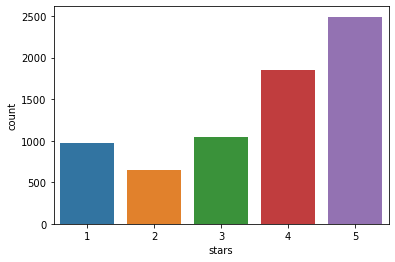

In [39]:
sns.countplot(filipino_las_vegas['stars'])

It seems that customers would prefer to rate Filipino restaurants higher ratings. The distribution shows that 5-star rating is the most common rating given to Filipino restaurants.

### Number of useful rating distribution of Las Vegas-Based Filipino Restaurants?

1.6645244215938304

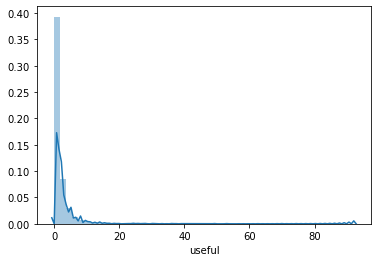

In [47]:
sns.distplot(filipino_las_vegas['useful']);

### Number of funny rating distribution of Las Vegas-Based Filipino Restaurants?

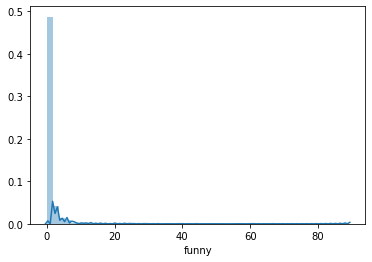

In [65]:
sns.distplot(filipino_las_vegas['funny']);

### Number of cool rating distribution of Las Vegas-Based Filipino Restaurants?

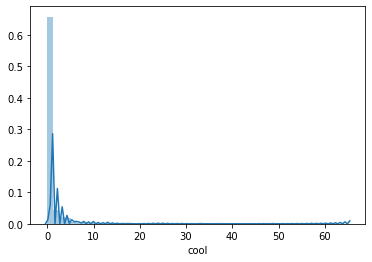

In [64]:
sns.distplot(filipino_las_vegas['cool']);

### What are the relationships between 'stars', 'cool', 'useful', and 'funny'?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


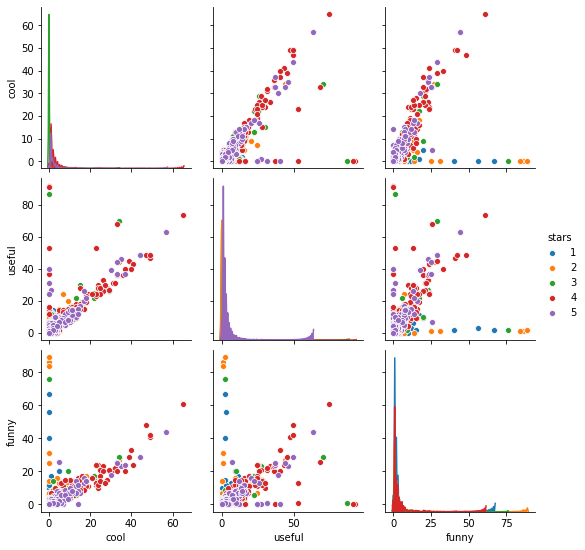

In [75]:
sns.pairplot(filipino_las_vegas[['stars', 'cool', 'useful', 'funny']],
             hue='stars')

Based on the exploratory data analysis, restaurants with more funny votes seem to have lower star ratings. Restaurants with more cool and useful votes seem to have higher star ratings

## 7  Latent Dirichlet Allocation

In this section, the dataset will be segregated into topics or latent factors using a method called **Latent Dirichlet Allocation**. The theory behind this method will be discussed in the subsequent sections. This section is divided into three parts:
- **7.1** Topic Discovery using Latent Dririchlet Allocation
- **7.2** Evaluating Topic Coherence using Pointwise Mutual Information (PMI)
- **7.3** Topic Clusters Visualization

### 7.1 Topic Discovery using Latent Dirichlet Allocation

Latent Dirichlet Allocation is a dimensionality reduction technique that uses a generative probabilsitic model for discovering abstract topics from documents. This dimensionality reduction method assumes that the documents or objects are random mixtures, and topics are probability distributions of words or tokens. LDA is a generative statistical mode, i.e. it is based on the joint probability distribution $P(X,Y)$, in contrast to discriminative model which are based on conditional probability $P(Y|X=x)$. 

LDA is three-level generative model, and be graphically represented as in **Figure 7.1** (sklearn).

<img src="./figure7.1.png" />

where

$D$ - Documents in the corpus<br>
$N$ - number of words in the sequence<br>
$K$ - number of topics in the corpus

In the graphical mode, the boxes represent repeated sampling and the nodes are random variabes. The objective is to infer hidden topics by observing the distribution of words in the documents. The term-topic probabilities and topic-document probabilities are modeled with Dirichlet ditribution (**Aggarwal, 2012**). The model requires prior knowledge about the number of topics $K$. The algorithm is described by the three steps below:

**Step 1**: Find the probability distribution of wods appearing in each topic $k\in K$. That is, $\beta_k\sim Dirichlet(\eta)$ where $\eta$ is the `topic_word_prior`.<br>
**Step 2**: Find the proportion of topics in each document $d \in D$. That is, $\theta_d\sim Dirichlet(\alpha)$ where $\alpha$ is the `doc_topic_prior`.<br>
**Step 3**: For each word $i$ in document $d$:
- infer topic assignment $z_{di}$ using $\text{Multinomial}(\theta_d)$
- identify observed word $w_{ij}$ using $\text{Multinomial}(\beta_{z_{di}})$

Whe LDA is appied to a term-document matrix (TF model), the matrix will be decomposed into `topic-term` matrix and `document-topic` matrix. To  illustrate,

### Figure 7.2 Complete Graph of a Topic Cluster

<img src="./figure7.2.png" alt="Drawing" style="width: 500px;"/>

In this study, LDA was used to cluster the topics inferred in the dataset. The number of topics was initially set at `n_components=20`. This study only aims to demostrate the ability of LDA in inferring hidden topics from a corpus. Thus,   hyperparameter tuning is beyond the scope. For initial trial, `learning_decay` was set at default value of `0.7`, and `batch_size` was increased to `700`. Learning method was set to `online` which is the one recommended for large data set (sklearn).

The transformation of the token frequencies yields the document-topic probability matrix of size $7002\times 20$. On the other hand, the topic-term matrix is obtained via `.components_` method of the fitted LDA model. These matrices can be visualized in **Figure 7.3** below. The first 10 documents in the document-topic matrix and first 10 tokens in the topic-term matrix are mapped with their probabilities and frequencies, respectively. The left figure shows the distribution of probabiltiies of the topics across different documents. Interesting, some documents mainly have dominant topic as given by higher probablitites. Most documents in the corpus are combination of different topics. The figure on the right side shows the frequencies of the words acros all 20 topics. As observed, there are words or tokens that were assigned majorly in one particular topic. Most of the topics are combinations of different tokens from different documents.

In [6]:
# Run Latent Dirichlet using n_components = 20

n = 20
LDA = LatentDirichletAllocation(n_components=n, learning_method='online', 
                              learning_decay=0.7, max_iter=100, batch_size=700, n_jobs=-1).fit(tf_reviews)
LDA_prob = LDA.transform(tf_reviews)
perplex = LDA.perplexity(tf_reviews)

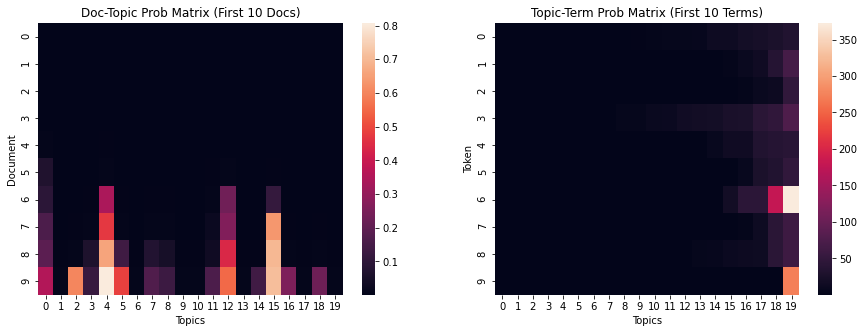

In [7]:
LDA_topic_term = LDA.components_
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(np.sort(LDA_prob[:10,:], axis=0), ax=ax1)
sns.heatmap(np.sort(LDA_topic_term[:, :10].T, axis=1), ax=ax2)
ax1.set_title('Doc-Topic Prob Matrix (First 10 Docs)')
ax2.set_title('Topic-Term Prob Matrix (First 10 Terms)')

ax1.set_xlabel('Topics')
ax2.set_xlabel('Topics')

ax1.set_ylabel('Document')
ax2.set_ylabel('Token');

**Figure 7.3** **(a)** Document-Topic Probability Matrix and **(b)** Topic-Term Probability Matrix

### 7.2 Evaluating Topic Coherence using Pointwise Mutual Information (PMI)

In this section, the topics discovered using LDA will be probed using a metric known as **Pointwise Mutual Information (PMI)**. The objective in this section is to determine how coherent and logical the topics are, and to eliminate topics which have low coherence scores.

In order to determine the significance of the topic clusters, a scoring based on Pointwise Mutual Information (PMI) was employed. Coherence refers to the sum of the pairwise scores of the words under a topic cluster (Pleple, 2013). That is,

$$
\text{Coherence}=\sum_{i<j}\text{score}(w_i, w_j)
$$

Usually, the top $n$ words are retrieved based on probabilities or frequencies in the corpus. The coherence score of a cluster can be graphicaly represented as the sum of all the edges in the complete graph as in **Figure 7.2.1**.

<img src="./figure7.2.1.png" />

The scoring function can be extrinsic or intrinsic to the dataset. In this study, the scoring function used was intrinsic UCI measure (Newman). The UCI uses a Pointwise Mutual Information (PMI) scoring function given by 

$$
\text{score}_{\text{UCI}}(w_i, w_j)=\log{\frac{p(w_i, w_j)}{p(w_i, w_j)}}
$$

where p(w) is the probability of occurence of the token $w_i$ in a random document, while $p(w_i, w_j)$ is the probability of seeing both words w_i and w_j co-occuring in a random document. The probabilities can be calculated from the word frequencies as given by

$$
p(w_i)=\frac{D_E(w_i)}{D_E}
$$

$$
p(w_i, w_j)=\frac{D_E(w_i, w_j)}{D_E}
$$

where $D(w_i)$ refers to the number of documents containing the word $w_i$, whlile $D(w_i, w_j)$ refers to the number of documents containing both words $w_i$ and $w_j$. $D_E$ is the number of documents from an extrinsic corpus. Usualy, the probabilities are estimated from an empirical document. However, in this study, the UCI was measured using the same intrinsic corpus. In addition, the scoring function was smoothened by adding one to $D(w_i)$.

Higher values of coherence means the topics are well-defined by their word constituents. Low values of coherence means that the constituent words have low degree of mutual information to explain the topic.

For each topic $k \in K$, where $K=20$, the sum of the pairwise PMIs were calculated. The coherence scores for each topic is given in **Figure 7.2.3**. The resulting values were standardized, that is $z=\dfrac{x-\mu}{\sigma}$ so that the values are scaled only in the top 20. The standardized values were plotted in a boxplot, and the threshold was determined. In this study, the threshold was set at the first quartile **Q1**. This is represented by the lower bound of the box. Thus, the topics with coherence score of less than the threshold will be removed.

Based on Figure **7.2.4**, the threshold is **-0.82**. Thus, the topics with standardized coherence score of less than **-0.82** were removed. Topics `0`, `3`, `9` and `18` were removed, leaving ony with **16** topic clusters. There clusters will be explored and visualized in the next section. 

In [8]:
def pmi(df_topic_pair_list):
    """Calculates the pairwise mutual information (pmi) of each topic.
    """
    coherence_dict = {}
    for i in range(len(df_topic_pair_list)):
        df_topic_list = df_topic_pair_list[i]
        list_scores = []
        for df in df_topic_list:
            ## calculates the probability of finding both words in one document
            pxy = sum((df.iloc[:, 0]>0) & (df.iloc[:, 1]>0)) + 1
            
            ## calculates the probability of finding word1 in random document
            px = (df.iloc[:, 0]>0).sum()
            
            ## calculates the probability of finding word2 in the same random document
            py = (df.iloc[:, 1]>0).sum()
            
            ## calculates the pairwise mutual information
            list_scores.append(np.log(len(df)*(pxy/(px*py))))
        
        ## calculates the sum of pairwise mutual information for all pairs w_i, w_j
        coherence_dict[i] = sum(list_scores)
    return coherence_dict

In [9]:
## get feature names from tf model
feature_names = tf.get_feature_names()

## combine tf model with feature names
tf_df = pd.DataFrame(tf_reviews.toarray(), columns=feature_names)

## get the top 20 words in each topic from the LDA model
top_topics = []
for j in range(20):
    top_topics.append([feature_names[np.argsort(LDA.components_[j])[::-1][:30][i]] for i in range(30)]) 

## create pair-wise combination of words in each topic
df_topic_pair_list = []
for i in range(20):
    df_topic_pair_list.append([tf_df[[pair[0], pair[1]]] for pair in list(combinations(top_topics[i], 2))])

In [10]:
pmi_reviews = pmi(df_topic_pair_list)

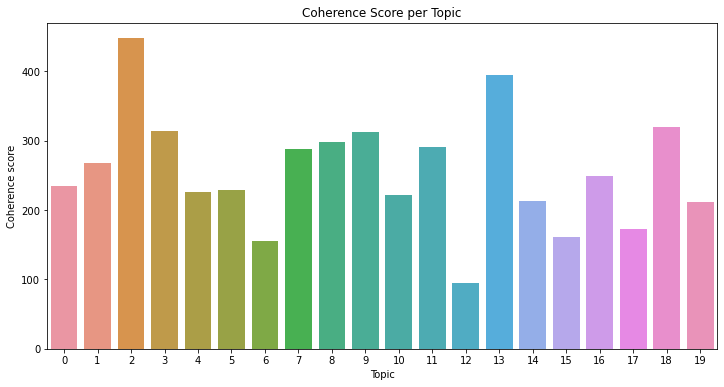

In [11]:
## sotre the coherence scores in dataframe
pmi_df = pd.DataFrame(pmi_reviews.values())

## plot the coherence scores of each topic

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=pmi_df.index, y=pmi_df[0], ax=ax)
ax.set_ylabel('Coherence score')
ax.set_xlabel('Topic')
ax.set_title('Coherence Score per Topic')
plt.show();

The filtered topics are [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 16, 18, 19] based on the minimum threshold of standardized PMI values.


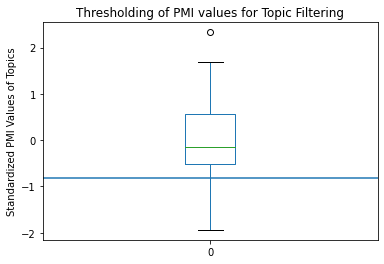

In [12]:


## standardize PMI values
pmi_std = pmi_df[0].apply(lambda x: (x-pmi_df.mean())/pmi_df.std())

## plot PMI values in boxplot
pmi_std.plot(kind='box')

## draw the threshold line
plt.axhline(-0.82)
plt.title('Thresholding of PMI values for Topic Filtering')
plt.ylabel('Standardized PMI Values of Topics')

## remove the topics below the minimum threshold
topics_filtered = pmi_std.loc[pmi_std[0] >= -0.82].index

print(f'The filtered topics are {list(topics_filtered)} based on the minimum threshold of standardized PMI values.')

### 7.3 Topic Clusters Visualization

In this section, the topic clusters identified were visualized and given with short interpretation. The objective of this section is to give an intution about the topic clusters formed. Further exploration per topic cluster will be discussed in section 8.

The LDA yields a document-topic probability matrix of size $7002 \times 20$. This matrix was used to the topic clusters in a cartesian plain using a more familiar dimensionality reduction method, called Singular Value Decomposition (**SVD**). The probability matrix was decomposed using SVD and the first two (and most important) singular vectors **SVs** were used as the principal axes. The  labels of the objects was obtained using KMeans with `n_clusters=16` as previously determined. Since dataset is a probability matrix, KMeans will assign each object a cluster based on their dominant topic, that is represented by the highest probability of the topic in the document.

The plot of the $SV_{1}$ vs $SV_{0}$ is given in **Figure 7.3.1**. Note that the total number of clusters may not be visually accurately represented as the number of singular vectors may not be enough to clearly show partitioning. Nonetheless, the figure shows a promising result of LDA, as there are clear partitioning of some topics.

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


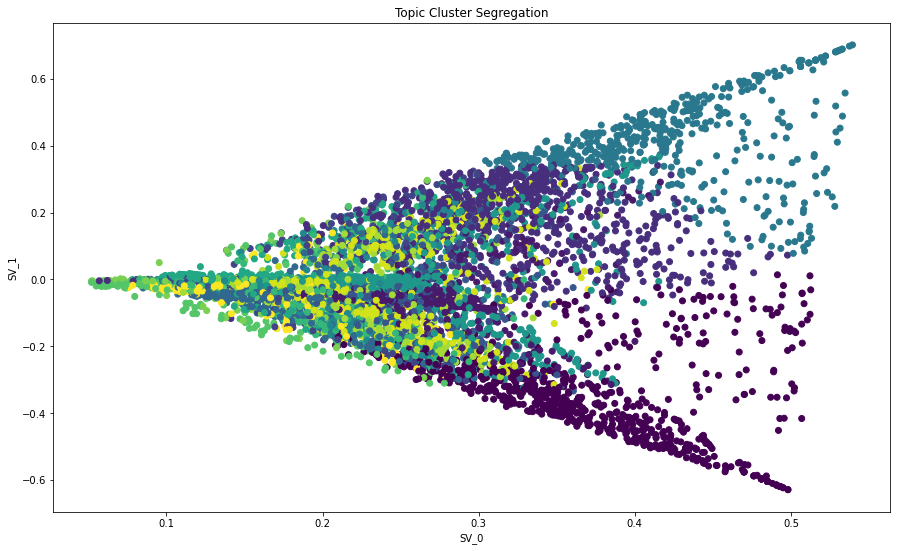

In [13]:
## project LDA probabilities in 2-dimension
X_trunc = (TruncatedSVD(n_components=2)
                    .fit_transform(LDA_prob))

km = KMeans(n_clusters=16, max_iter=300, tol=1e-4, n_jobs=-1).fit(LDA_prob)
y_pred = km.predict(LDA_prob)

## plot the topics in cartesian plane
fig, ax = plt.subplots(figsize=(15, 9))
ax.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred)
ax.set_title('Topic Cluster Segregation')
ax.set_xlabel('SV_0')
ax.set_ylabel('SV_1')
plt.show();

To give a more intuitive representation of the topic clusters, wordcloud for each topic was created. It is important to note here that the wordclouds were created based on probabilties, such that words with higher probability were magnified, and less relevant words were shrunk. It is interesting to observe that most clusters are dominantly explained by 2-4 words. These words are the most important words in the topic clusters are bear the highest probabilities. These wordclouds were given more interpretation in the next section.

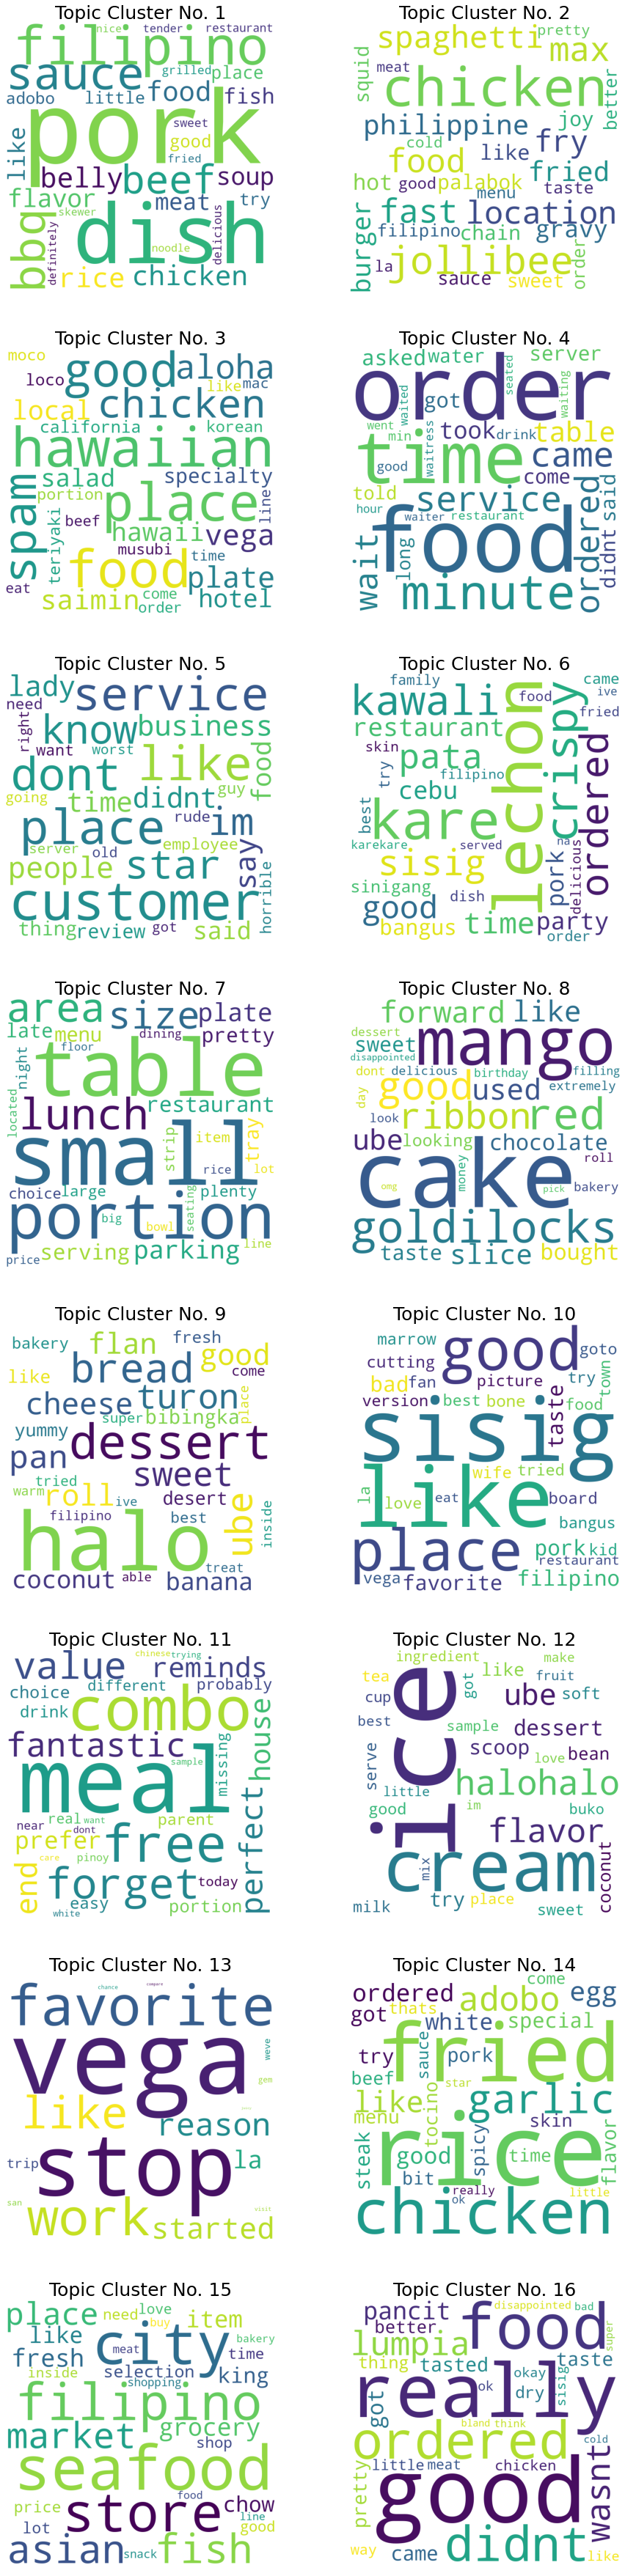

In [76]:
## create axes for containment
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), 
      (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16)) = plt.subplots(8, 2, figsize = (15, 50), facecolor = None) 

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, 
           ax11, ax12, ax13, ax14, ax15, ax16]

for j, i in enumerate(topics_filtered):
    data = dict(pd.DataFrame(LDA.components_, columns=feature_names)[top_topics[i]].loc[i])
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate_from_frequencies(data) 
    ax_list[j].imshow(wordcloud) 
    ax_list[j].axis("off")
    ax_list[j].set_title(f'Topic Cluster No. {j+1}', fontsize=25)

plt.tight_layout(pad = 5) 
plt.show()

## 8 Topic Cluster Explorations

In this section, the individual clusters were explored and given with more in-depth interpretation.

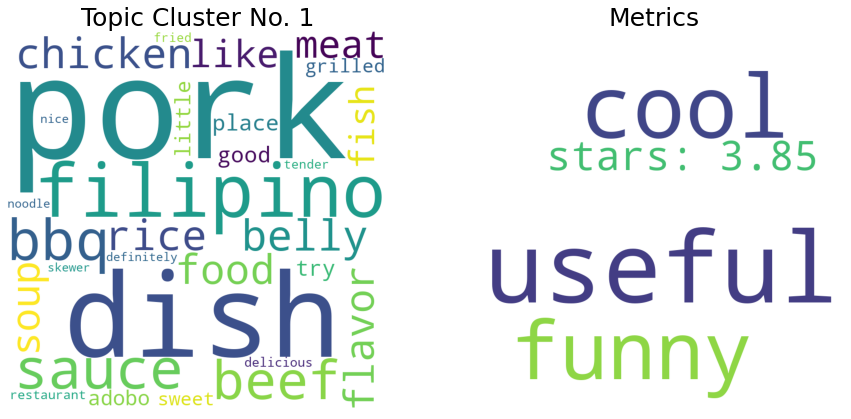

In [77]:
def plot_cluster_metric(j):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    ## retrieve cluster data
    i = topics_filtered[j]
    cluster = pd.DataFrame(LDA.components_, columns=feature_names)[top_topics[i]].loc[i]
    data = dict(cluster)
    wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        min_font_size = 10).generate_from_frequencies(data) 

    ## plot topic words in cluster
    ax1.imshow(wordcloud) 
    ax1.axis("off")
    ax1.set_title(f'Topic Cluster No. {j+1}', fontsize=25)

    ## calculate metrics from original data
    index = tf_df[cluster.index].sum(axis=1).sort_values(ascending=False)[:20].index
    metrics = filipino_las_vegas.loc[index][['useful', 'funny', 'cool']].sum()
    data = dict(metrics)
    stars = filipino_las_vegas.loc[index]['stars'].mean()
    data[f'stars: {stars}'] = stars
    wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        min_font_size = 10).generate_from_frequencies(data) 

    ax2.imshow(wordcloud) 
    ax2.axis("off")
    ax2.set_title('Metrics', fontsize=25)
    return None

plot_cluster_metric(0)

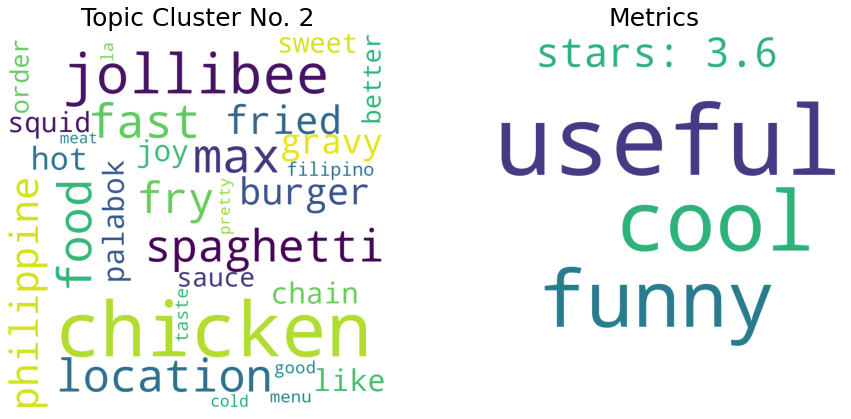

In [78]:
plot_cluster_metric(1)

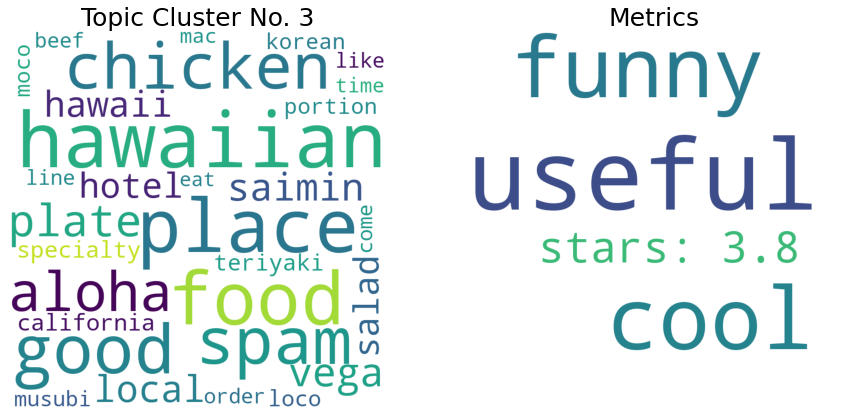

In [79]:
plot_cluster_metric(2)

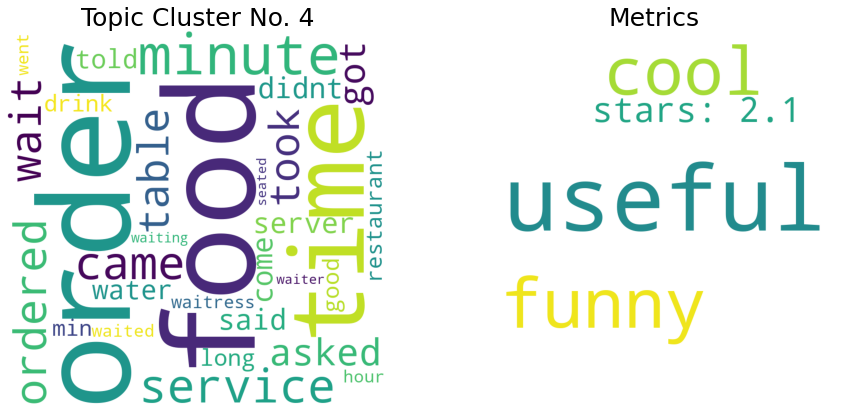

In [94]:
plot_cluster_metric(3)

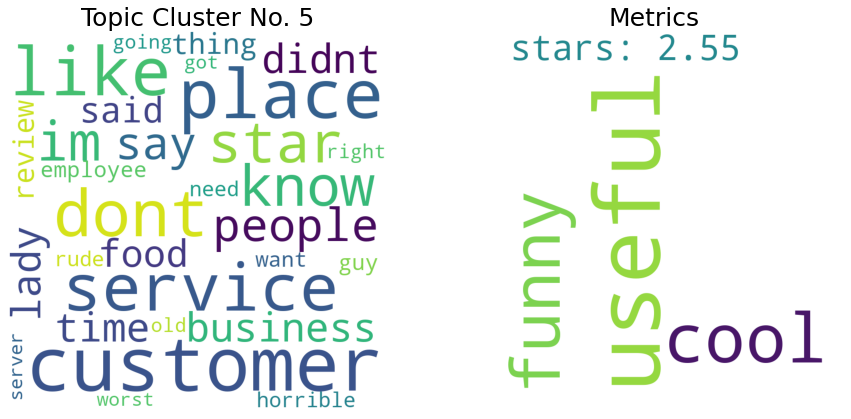

In [81]:
plot_cluster_metric(4)

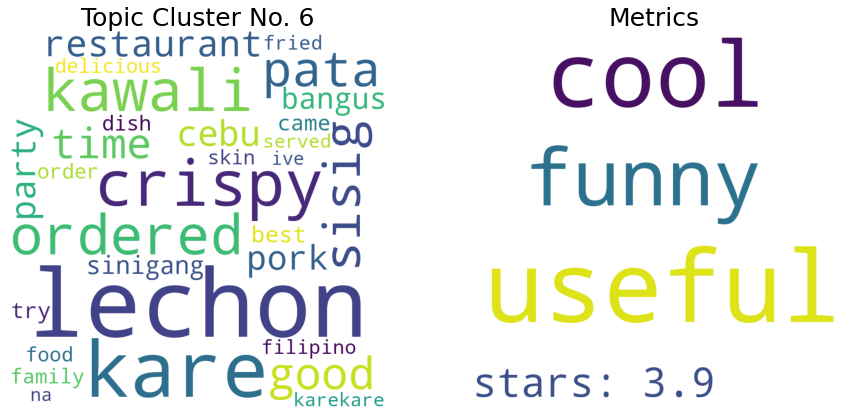

In [82]:
plot_cluster_metric(5)

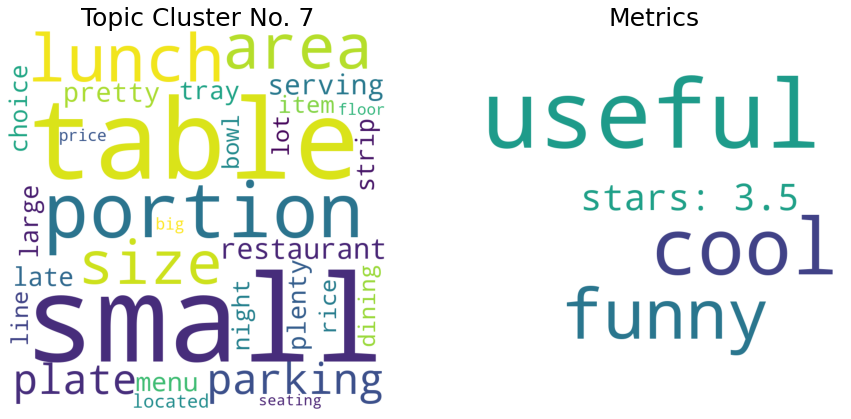

In [83]:
plot_cluster_metric(6)

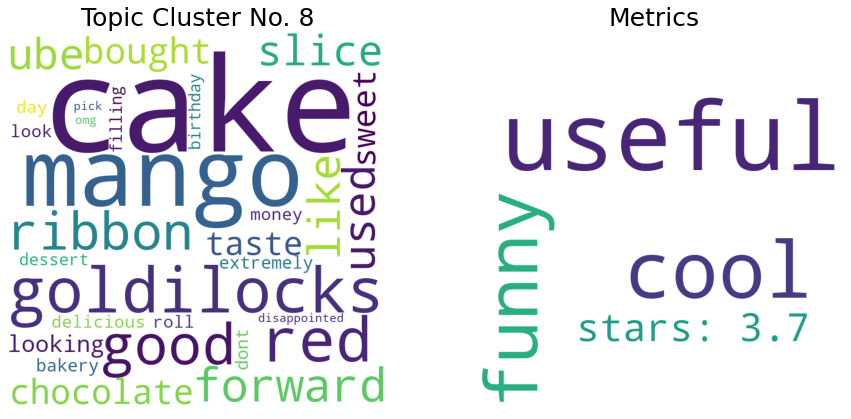

In [84]:
plot_cluster_metric(7)

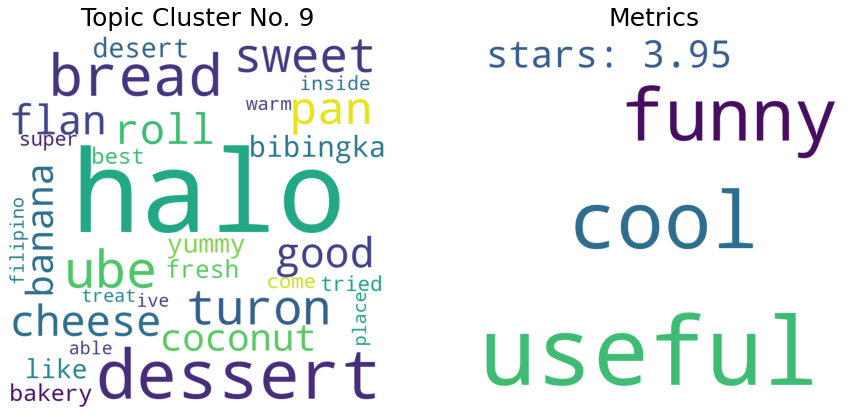

In [85]:
plot_cluster_metric(8)

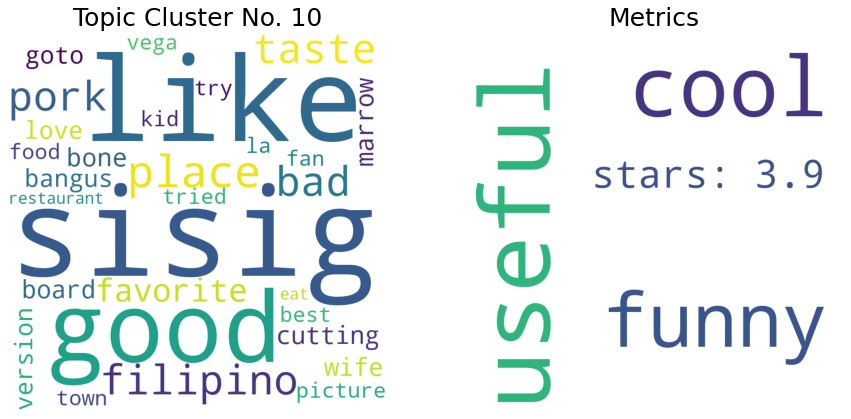

In [86]:
plot_cluster_metric(9)

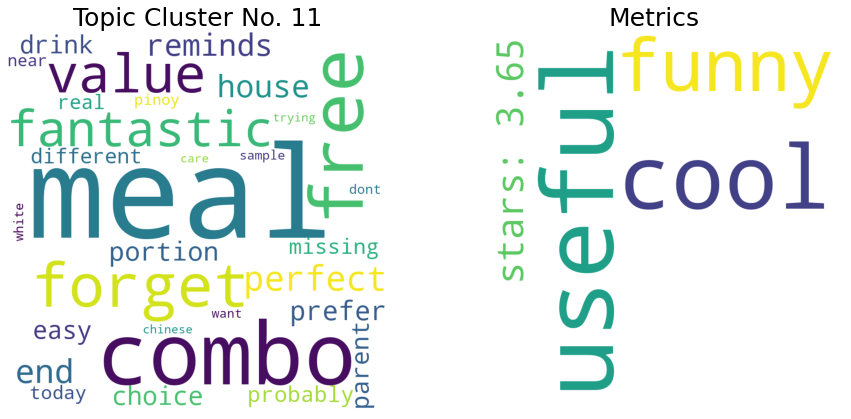

In [87]:
plot_cluster_metric(10)

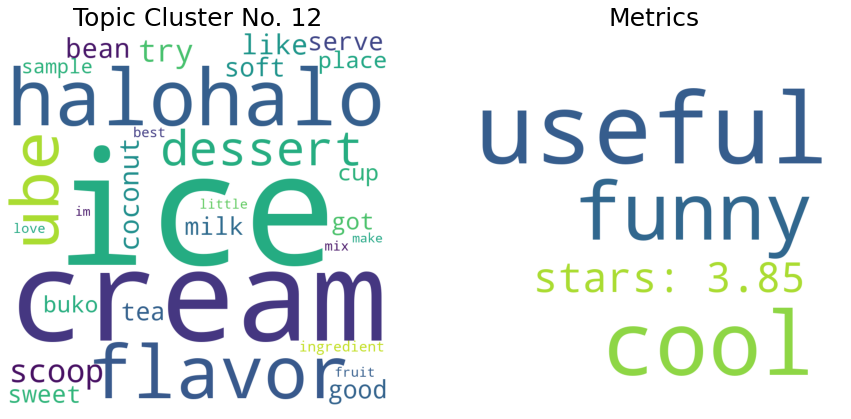

In [88]:
plot_cluster_metric(11)

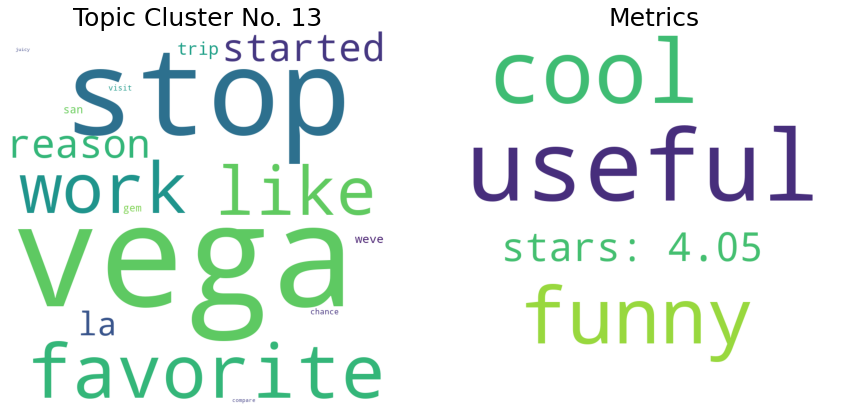

In [89]:
plot_cluster_metric(12)

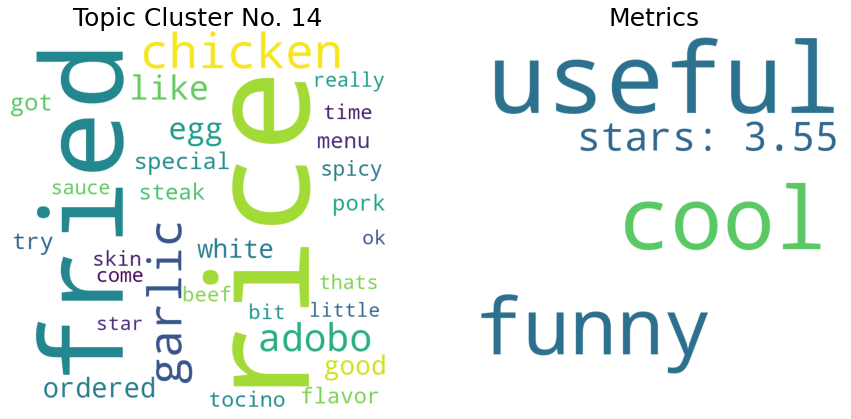

In [90]:
plot_cluster_metric(13)

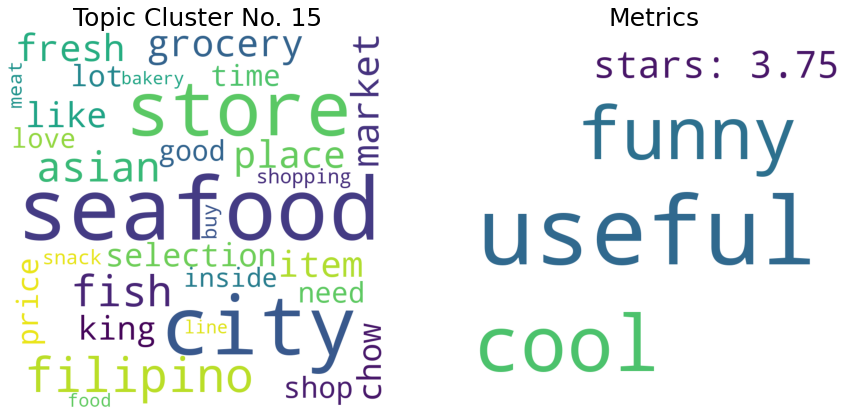

In [91]:
plot_cluster_metric(14)

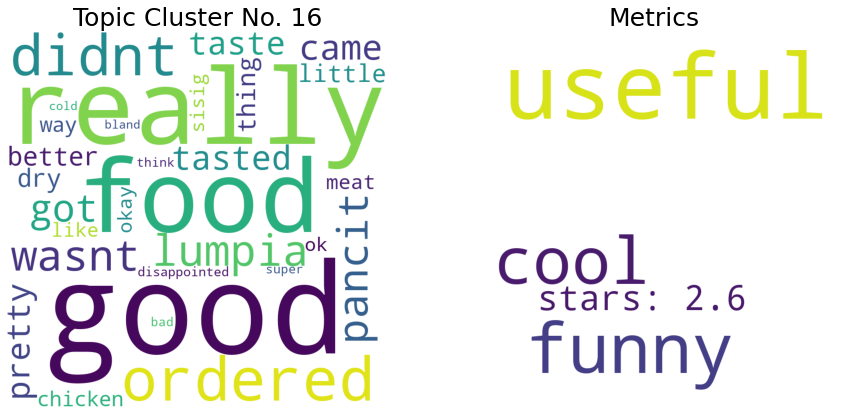

In [92]:
plot_cluster_metric(15)

The different clusters resonate the different experiences and sentiments on Filipino cuisine. The following are descriptions of each cluster:

1. Barbeque and meat dishes experiences. 
2. Filipino fast food restaurant experiences
3. Filipino fusion with Hawaiian, Californian and Korean food experiences.
4. Long service time experience.
5. Poor customer service experience.
6. Filipino party food experience.
7. Quick eats and lunch experience
8. Filipino bakeries and cakes experience.
9. Desserts and merienda experiences.
10. Sisig experience.
11. Affordable and valuable food experience.
12. Cold desserts such as halo-halo ice cream.
13. Favorite Filipino restaurants. 
14. Filipino breakfast experience.
15. Filipino seafood experience.
16. Underwhelming taste and flavors.

## 10 Conclusion

In this study, a dimensionality reduction method called Latent Dirichlet Allocation was applied to discover topics from customer reviews of Filipino restuarants in Las Vegas. Using LDA, 16 topics were selected based on Quartile 1 threshold of standardized coherence score defined by Pointwise Mutual Information (PMI).  The 2-dimensional plot of the projection of the document-topic probability matrix showed defined boundaries between topics obtained from LDA. The words constituents of each topic were also explored and were used to given proper interpretation of the topic cluster. 

The clusters repetitively shows a relatively limited view of Filipino cuisine. Moreover, the highlighted experience have shown that Filipino food is either limited to the popular Filipino dishes, desserts, seafood, and underwhelming food experience. Moreover, the ratings of the clusters have also shown Filipino food are considered mid-tier. There are no fine dining Filipino food or any other provincial Filipino food. In short, the market sentiments have shown that Filipino cuisine lack of diversity and innovation.

## 11 Recommendation

On the Filipino cuisine aspect, it is recommended that DTI consider to either innovate on the popular Filipino food that was mentioned in the research or consider to introduce provincial Filipino food. This would also promtpt Filipino food technology company and Filipino restaurants to innovate on the current Filipino. Also, it is recommended that they fundamentally study taste and flavors preference of mainstream food to apply it to the Filipino cuisine.

On the technical aspect, the hyperparameters used for LDA were not optimized. Specifically, the number of components and learning decay. In most literatures, the optimum number of components can be objectively found by cross-validation and calculating the mean coherence score for each fold. Thus, the authors recommend to conduct LDA using k-fold cross validation and calculate the resulting mean coherence scores. The optimum number of topic is found by plotting the coherence score to the number of topics.

It is also recommended to compare the coherence score using other scoring functions. The one used in this study was UCI based on Pointwise Mutual Information. However, the corpus used for calculating UCI was the same corpus used in the LDA. It is highly recommended to compare the UCI score using other empirical dataset. 

Another hyperparameter recommended for tuning is the learning decay. The learning decay ranges from 0 to 1, and affects the quality of topic clusters. It suggested to perform hyperparameter tuning playing around with both number of components and learning decay. 

## 12 References

Aggarwal, C. C. (2015). Data Mining: The Textbook. Cham: Springer. ISBN: 978-3-319-14141-1<br>

Blei, D. M., Ng, A. Y. & Jordan, M. I. (2003). Latent Dirichlet Allocation. J. Mach. Learn. Res., 3, 993--1022.<br>

Cruz, C. (2019). A Westerner said 'Filipino food is the worst.' Here's why we care so much. CNN Philippines. Retrieved from 
https://cnnphilippines.com/life/leisure/food/2019/5/6/westerners-filipino-food-essay.html.

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.<br>

Hamon, T., Pleplé, Q., Paroubek, P., Zweigenbaum, P. & Grouin, C. (2014). Automatic Analysis of Scientific and Literary Texts. Presentation and Results of the DEFT2014 Text Mining Challenge (Analyse automatique de textes littéraires et scientifiques : présentation et résultats du défi fouille de texte DEFT2014) [in French].. In C. Grouin (ed.), DEFT@TALN (p./pp. 1-10), : Association pour le Traitement Automatique des Langues.

Mimno, D. M., Wallach, H. M., Talley, E. M., Leenders, M. & McCallum, A. (2011). Optimizing Semantic Coherence in Topic Models.. EMNLP (p./pp. 262-272), : ACL. ISBN: 978-1-937284-11-4.

Salcedo, M. (2019). These Filipino foods are set to dominate the world stage. inquirer. Retrieved from https://business.inquirer.net/272241/these-filipino-foods-are-set-to-dominate-the-world-stage.
